# Задание

Обучить сиамскую сеть для верификации лиц на датасете LFW

# Обучение эмбеддингов (Metric Learning)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import random

## Загрузка датасета lfw.

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'lfw',
     split=['train[:90%]', 
            'train[90%:]'],    
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [3]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    full_name='lfw/0.1.0',
    description="""
    Labeled Faces in the Wild:
            A Database for Studying Face Recognition in
            Unconstrained Environments
    """,
    homepage='http://vis-www.cs.umass.edu/lfw',
    data_path='~/tensorflow_datasets/lfw/0.1.0',
    file_format=tfrecord,
    download_size=172.20 MiB,
    dataset_size=180.28 MiB,
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('label', 'image'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=13233, num_shards=2>,
    },
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Am

In [4]:
len(ds_train)

11910

In [3]:
ds_train=ds_train.take(6000)

Визуализация датасета

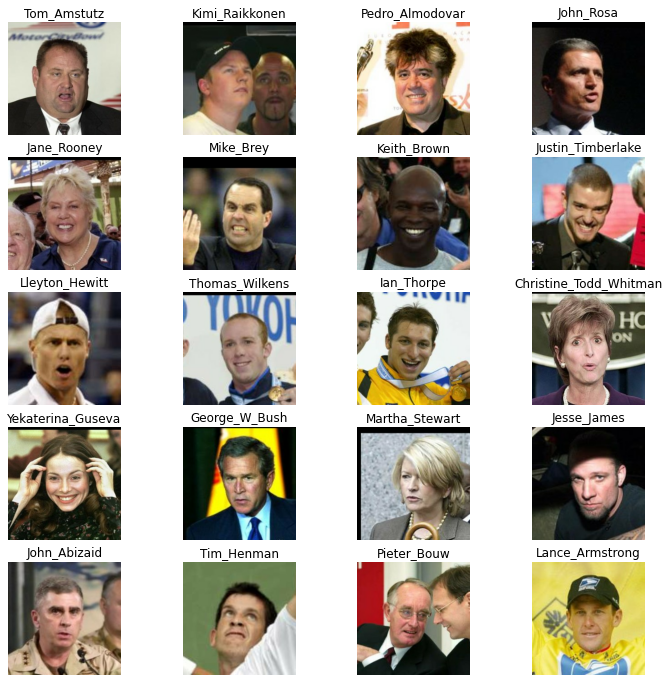

In [6]:
plt.figure(figsize=(12, 12))
for i, x in enumerate(ds_train.take(20)):
    plt.subplot(5, 4, i+1)
    plt.title(x[0].numpy().decode('utf-8'))
    plt.imshow(x[1])
    plt.axis('off')

## Contrastive Loss

Подготовка данных.

In [4]:
INP_SIZE = 128
BATCH_SIZE = 128
# к сожалению большее количество эпох Коллаб не потянул.
EPOCHS = 5

def prepare_images(label, img):
    img = tf.cast(img, tf.float32) / 255.
    img = tf.image.resize(img, (INP_SIZE, INP_SIZE))
    return img, label

ds_train = ds_train.map(prepare_images)
ds_train = ds_train.repeat(EPOCHS)
ds_train = ds_train.shuffle(buffer_size=len(ds_train))
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(prepare_images)
ds_test = ds_test.batch(BATCH_SIZE)

Создание модели CNN

In [5]:
EMB_SIZE = 128

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

In [6]:
MARGIN = 5.0

def contrastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    print(d)
    
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

Подготовка к обучению

In [7]:
LEARNING_RATE = 0.0000001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

Обучение модели

In [8]:
%%time

NUM_EPOCHS = 30

for epoch in range(NUM_EPOCHS):
    for iteration, (images, labels) in enumerate(ds_train):
    
        # Forward
        with tf.GradientTape() as tape:
            embs = model(images)
            loss_value = contrastive_loss(embs, labels)
        
        # Backward
        grads = tape.gradient(loss_value, model.variables)
        optimizer.apply_gradients(zip(grads, model.variables))

        if iteration % 20 == 0:
            print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))
        if loss_value.numpy() == 0.:
            break

Выходные данные были обрезаны до нескольких последних строк (5000).
[ 7.2956004 18.841465   5.5941296  4.809766   4.220663   5.5840793
  2.9568694  7.207171   5.9813323  7.7354994  8.71868   14.551034
  6.5468993  4.561908   6.0152807  6.610455   4.1164947  5.5611362
  6.850011   6.2200384 10.984613   5.8910933  2.8436456  7.6644707
  3.7806215  6.299752   6.837094   6.650308   5.999125   8.361526
 19.114677   3.8578506  6.239798   6.75428    3.5688527  6.0884852
  4.1288004  5.2304673  8.038701   4.1419096  7.0634646  7.7304497
  3.6626418  7.6139045 13.265573   8.492164  12.475154   5.834833
  2.9665341  5.334467   4.3660536  4.920434   7.0547376  6.1365037
  3.403688   5.52869    8.807766   3.632267   4.36509    5.3307524
  3.3265426  5.464884   4.4046955  8.568509 ], shape=(64,), dtype=float32)
tf.Tensor(
[17.66682    3.8393757  5.9220467  6.1963034 16.51698    6.5814295
  3.7605088  7.739851   5.0992193  8.96717    5.304534   8.631126
  7.7405186  9.770067   5.114796  11.766508   

Получение эмбеддингов для тестовой выборки

In [9]:
test_labels = []
for i, x in enumerate(ds_test.take(len(ds_test))):
    if i ==0:
        test_images = x[0]
        test_labels = (list(x[1].numpy()))
    else:
        test_images = np.vstack([test_images, x[0]])
        test_labels = test_labels + list(x[1].numpy())

test_embs = model(test_images) 

Функция для визуализации эмбеддингов

In [10]:
def draw_embeddings(X_embedded, targets):
    
    pic_idx_list = np.random.randint(0,len(targets),50)
    
    plt.figure(figsize=(21, 12))
    for i in pic_idx_list:
        
        x, y = X_embedded[i,:] 
        plt.scatter(x, y)
        plt.annotate(str(targets[i], 'utf-8'), xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom', fontsize=12)  
    plt.show()

Визуализация эмбеддингов в 2D пространстве с помощью TSNE

In [11]:
test_embs_2D = TSNE(n_components=2).fit_transform(test_embs[:1000])
labels_for_viz = test_labels[:1000]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


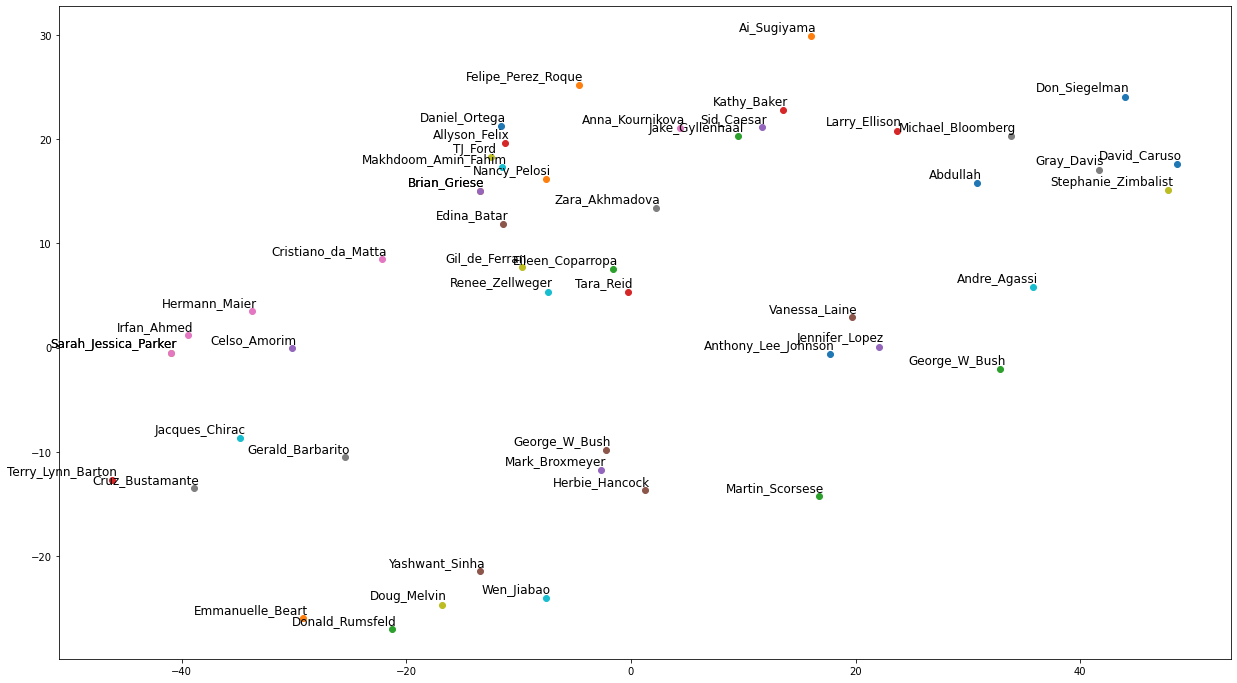

In [12]:
draw_embeddings(test_embs_2D, labels_for_viz)

Вычисление расстояний между эмбеддингами

In [13]:
GBuch_emb = []
GBuch_pic = []
BClinton_emb = []
BClinton_pic = []
for i, person in enumerate(test_labels):
    if str(person, 'utf-8') == 'George_W_Bush':
        GBuch_emb.append(test_embs[i])
        GBuch_pic.append(test_images[i])        
    if str(person, 'utf-8') == 'Bill_Clinton':
        BClinton_emb.append(test_embs[i])    
        BClinton_pic.append(test_images[i])              
        

(-0.5, 127.5, 127.5, -0.5)

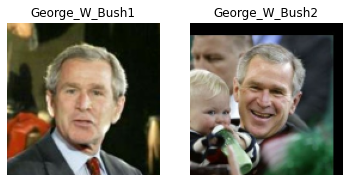

In [14]:
plt.figure()
plt.subplot(1, 2, 1)
plt.title('George_W_Bush1')
plt.imshow(GBuch_pic[12])
plt.axis('off')
plt.subplot(1, 2, 2)

plt.title('George_W_Bush2')
plt.imshow(GBuch_pic[13])
plt.axis('off')


(-0.5, 127.5, 127.5, -0.5)

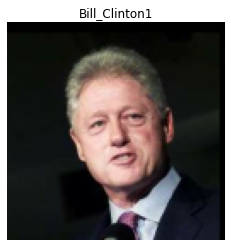

In [15]:
plt.figure()
plt.title('Bill_Clinton1')
plt.imshow(BClinton_pic[1])
plt.axis('off')

In [16]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5


emb1 = GBuch_emb[12]
emb2 = GBuch_emb[13]

emb3 = BClinton_emb[1]

print('George_W_Bush1 <-> George_W_Bush2: ', diff(emb1, emb2))
print('George_W_Bush2 <-> Bill_Clinton1: ', diff(emb2, emb3))
print('George_W_Bush1 <-> Bill_Clinton1: ', diff(emb1, emb3))

George_W_Bush1 <-> George_W_Bush2:  4.8239722308597965
George_W_Bush2 <-> Bill_Clinton1:  9.07040502482955
George_W_Bush1 <-> Bill_Clinton1:  4.864626680735113


# Triplet_loss

In [17]:
(ds_train, ds_test), ds_info = tfds.load(
    'lfw',
     split=['train[:90%]', 
            'train[90%:]'],    
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [19]:
df = pd.DataFrame({'name':[None], 'img':[None]})
for i, x in enumerate(ds_train.take(len(ds_train))):
    df.loc[i] = {'name':x[0].numpy().decode('utf-8'), 'img':x[1]}

In [20]:
df.head()

,name,img
0,John_Abizaid,"(((tf.Tensor(33, shape=(), dtype=uint8), tf.Te..."
1,Tim_Henman,"(((tf.Tensor(106, shape=(), dtype=uint8), tf.T..."
2,Pieter_Bouw,"(((tf.Tensor(143, shape=(), dtype=uint8), tf.T..."
3,Lance_Armstrong,"(((tf.Tensor(228, shape=(), dtype=uint8), tf.T..."
4,John_Marburger,"(((tf.Tensor(0, shape=(), dtype=uint8), tf.Ten..."


In [21]:
INP_SIZE = 128
BATCH_SIZE = 128
EPOCHS = 1

def prepare_images(label, img):
    img = tf.cast(img, tf.float32) / 255.
    img = tf.image.resize(img, (INP_SIZE, INP_SIZE))
    return img, label

ds_train = ds_train.map(prepare_images)
ds_train = ds_train.repeat(EPOCHS)
ds_train = ds_train.shuffle(buffer_size=len(ds_train))
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [22]:
from collections import Counter
my_dict = Counter(df['name'])
my_dict = dict(my_dict)

In [25]:
df_count = pd.DataFrame({'name': list(my_dict.keys()), 'count': list(my_dict.values())})

In [26]:
df_count.head()

,name,count
0,John_Abizaid,9
1,Tim_Henman,18
2,Pieter_Bouw,1
3,Lance_Armstrong,17
4,John_Marburger,1


In [27]:
#msk_anchor = df_count['count'] > 1
df_anchor = df_count.loc[df_count['count'] > 1]

#msk_negative = df_count['count'] == 1
df_negative = df_count.loc[df_count['count'] == 1] 
print(f"Anchor_nmb: {df_anchor.shape[0]}")
print(f"Negative_nmb: {df_negative.shape[0]}")

Anchor_nmb: 1531
Negative_nmb: 3795


In [28]:
anchor_list = df_anchor["name"].to_list()
anchor2id = {name:id for id, name in enumerate(anchor_list)}
id2anchor = {id:name for name, id in anchor2id.items()}

images_nmb_list = df_anchor["count"].to_list()
id2images_nmb = {id: int(nmb) for id, nmb in enumerate(images_nmb_list)}

negative_list = df_negative["name"].to_list()
negative_size = len(negative_list)

In [29]:
df.loc[0]

name                                         John_Abizaid
img     (((tf.Tensor(33, shape=(), dtype=uint8), tf.Te...
Name: 0, dtype: object

In [30]:
id2anchor[700]

'Laila_Ali'

In [31]:
images_list = df_anchor["name"].apply(lambda x: anchor2id[x]).to_list()

In [32]:
def _read_images(img_par):
    anchor_id = img_par.numpy()
            
    name = id2anchor[anchor_id]
    nmb = random.randint(0, id2images_nmb[anchor_id]-1)
    img_anchor = list(df.loc[df['name']==name]['img'])[nmb]
    #io.imread(f"{root_path}/{name}/{name}_{nmb:04d}.jpg")
            
    nmb = random.sample([i for i in range(0, id2images_nmb[anchor_id]) if i != nmb],1)[0]
    img_positive = list(df.loc[df['name']==name]['img'])[nmb]
    #io.imread(f"{root_path}/{name}/{name}_{nmb:04d}.jpg")

    name = negative_list[random.randint(0, negative_size-1)]
    img_negative = list(df.loc[df['name']==name]['img'])[0]
    #io.imread(f"{root_path}/{name}/{name}_0001.jpg")
    #img_negative = io.imread("../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Aaron_Guiel/Aaron_Guiel_0001.jpg")
            
    return np.concatenate([img_anchor, img_positive, img_negative],axis=2)

In [33]:
def _item_to_images(item):     
    img = tf.py_function(_read_images, [item], tf.uint8)
    img_anchor = tf.cast(img[...,:3], tf.float32) / np.float32(255.)
    img_positive = tf.cast(img[...,3:6], tf.float32) / np.float32(255.)
    img_negative = tf.cast(img[...,6:], tf.float32) / np.float32(255.)
    return img_anchor, img_positive, img_negative

In [34]:
ds_train = tf.data.Dataset.from_tensor_slices(images_list)

In [35]:
len(ds_train)

1531

In [36]:
ds_train = ds_train.map(_item_to_images)

In [37]:
ds_train = ds_train.batch(64//3*3, drop_remainder=True)

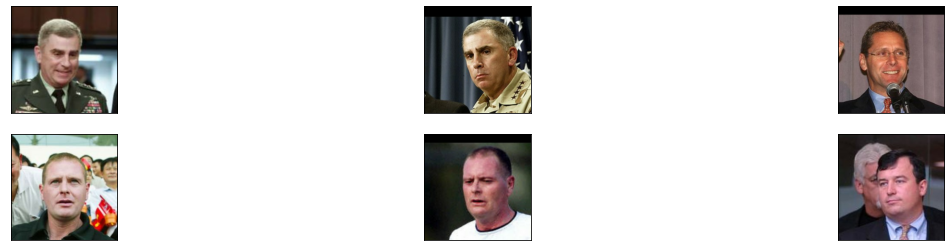

In [38]:
fig = plt.figure(figsize=(21, 9))
for j, (img1, img2, img3) in enumerate(ds_train.take(2)):
    ax = fig.add_subplot(4, 3, 3*j+1)
    ax.imshow(img1[0,...])
    plt.xticks([]), plt.yticks([])

    ax = fig.add_subplot(4, 3, 3*j+2)
    ax.imshow(img2[0,...])
    plt.xticks([]), plt.yticks([])
    
    ax = fig.add_subplot(4, 3, 3*j+3)
    ax.imshow(img3[0,...])
    plt.xticks([]), plt.yticks([])

plt.show()

In [39]:
MARGIN = 20.0

def triplet_loss(embs_anchor, embs_positive, embs_negative):
   
    return tf.reduce_mean(tf.maximum(0, tf.square(embs_anchor - embs_positive) - tf.square(embs_anchor - embs_negative) +  MARGIN))

In [54]:
EMB_SIZE = 128

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

In [55]:
LEARNING_RATE = 0.00001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

Обучение модели

In [56]:
%%time

NUM_EPOCHS = 40

for epoch in range(NUM_EPOCHS):
    for iteration, (images_anchor, images_positive, images_negative) in enumerate(ds_train):

        # Forward
        with tf.GradientTape() as tape:
            embs_anchor = model(images_anchor)
            embs_positive = model(images_positive)
            embs_negative = model(images_negative)
            loss_value = triplet_loss(embs_anchor, embs_positive, embs_negative)

        # Backward
        grads = tape.gradient(loss_value, model.variables)
        optimizer.apply_gradients(zip(grads, model.variables))

        if iteration % 20 == 0:
            print('{}[{}] Loss: {}'.format(epoch, iteration, loss_value.numpy()))

0[0] Loss: 19.999826431274414
0[20] Loss: 19.979808807373047
1[0] Loss: 20.01325225830078
1[20] Loss: 19.842443466186523
2[0] Loss: 19.854089736938477
2[20] Loss: 18.759485244750977
3[0] Loss: 19.60847282409668
3[20] Loss: 19.828025817871094
4[0] Loss: 18.739683151245117
4[20] Loss: 19.122528076171875
5[0] Loss: 19.54663848876953
5[20] Loss: 17.406545639038086
6[0] Loss: 17.379669189453125
6[20] Loss: 18.203752517700195
7[0] Loss: 17.58251190185547
7[20] Loss: 18.03292465209961
8[0] Loss: 16.994571685791016
8[20] Loss: 15.780540466308594
9[0] Loss: 16.811906814575195
9[20] Loss: 15.861308097839355
10[0] Loss: 16.673912048339844
10[20] Loss: 16.226085662841797
11[0] Loss: 17.552753448486328
11[20] Loss: 16.68122673034668
12[0] Loss: 15.637813568115234
12[20] Loss: 16.66873550415039
13[0] Loss: 15.631634712219238
13[20] Loss: 14.386489868164062
14[0] Loss: 14.456950187683105
14[20] Loss: 16.067319869995117
15[0] Loss: 15.515807151794434
15[20] Loss: 15.377717018127441
16[0] Loss: 16.1429

# Тестирование модели с Triplet_loss

In [71]:
(ds_train, ds_test), ds_info = tfds.load(
    'lfw',
     split=['train[:90%]', 
            'train[90%:]'],    
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [72]:
df = pd.DataFrame({'name':[None], 'img':[None]})
for i, x in enumerate(ds_train.take(len(ds_test))):
    df.loc[i] = {'name':x[0].numpy().decode('utf-8'), 'img':x[1]}

In [73]:
INP_SIZE = 128
BATCH_SIZE = 128
EPOCHS = 1

def prepare_images(label, img):
    img = tf.cast(img, tf.float32) / 255.
    img = tf.image.resize(img, (INP_SIZE, INP_SIZE))
    return img, label

ds_test = ds_test.map(prepare_images)
ds_test = ds_test.batch(BATCH_SIZE)

In [74]:
from collections import Counter
my_dict = Counter(df['name'])
my_dict = dict(my_dict)

In [75]:
df_count = pd.DataFrame({'name': list(my_dict.keys()), 'count': list(my_dict.values())})

In [76]:
#msk_anchor = df_count['count'] > 1
df_anchor = df_count.loc[df_count['count'] > 1]

#msk_negative = df_count['count'] == 1
df_negative = df_count.loc[df_count['count'] == 1] 
print(f"Anchor_nmb: {df_anchor.shape[0]}")
print(f"Negative_nmb: {df_negative.shape[0]}")

Anchor_nmb: 148
Negative_nmb: 801


In [77]:
anchor_list = df_anchor["name"].to_list()
anchor2id = {name:id for id, name in enumerate(anchor_list)}
id2anchor = {id:name for name, id in anchor2id.items()}

images_nmb_list = df_anchor["count"].to_list()
id2images_nmb = {id: int(nmb) for id, nmb in enumerate(images_nmb_list)}

negative_list = df_negative["name"].to_list()
negative_size = len(negative_list)

In [78]:
images_list = df_anchor["name"].apply(lambda x: anchor2id[x]).to_list()

In [79]:
ds_test = tf.data.Dataset.from_tensor_slices(images_list)

In [80]:
ds_test = ds_test.map(_item_to_images)

In [81]:
ds_test = ds_test.batch(64//3*3, drop_remainder=True)

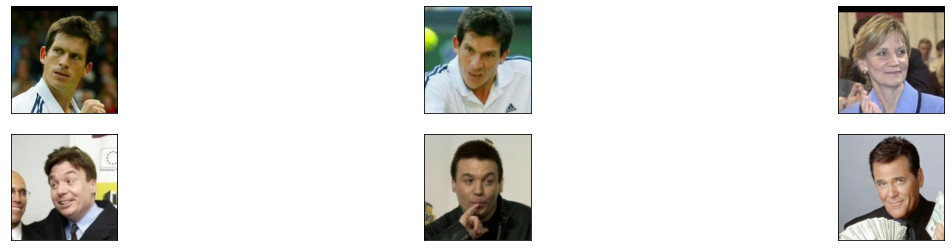

In [82]:
fig = plt.figure(figsize=(21, 9))
for j, (img1, img2, img3) in enumerate(ds_test.take(2)):
    ax = fig.add_subplot(4, 3, 3*j+1)
    ax.imshow(img1[0,...])
    plt.xticks([]), plt.yticks([])

    ax = fig.add_subplot(4, 3, 3*j+2)
    ax.imshow(img2[0,...])
    plt.xticks([]), plt.yticks([])
    
    ax = fig.add_subplot(4, 3, 3*j+3)
    ax.imshow(img3[0,...])
    plt.xticks([]), plt.yticks([])

plt.show()

In [83]:
dd = iter(ds_test)
images_anchor, images_positive, images_negative = dd.next()
test_embs_anchor = model(images_anchor)
test_embs_positive = model(images_positive)
test_embs_negative = model(images_negative)

In [86]:
#def diff(e1, e2):
 #   return np.sum((e1 - e2)**2) ** 0.5
for i in range(5):
    emb1 = test_embs_anchor[i,:]
    emb2 = test_embs_positive[i,:]
    emb3 = test_embs_negative[i,:]

    print('A1 <-> A2: ', diff(emb1, emb2))
    print('A2 <-> B1: ', diff(emb2, emb3))
    print('A1 <-> B1: ', diff(emb1, emb3))
    print("xxxxxxxxxxxxxxxxxxxxxxxx")

A1 <-> A2:  16.24526298143362
A2 <-> B1:  129.85678710121394
A1 <-> B1:  115.27416368163337
xxxxxxxxxxxxxxxxxxxxxxxx
A1 <-> A2:  28.296864215210533
A2 <-> B1:  51.39029482639451
A1 <-> B1:  24.479484843898497
xxxxxxxxxxxxxxxxxxxxxxxx
A1 <-> A2:  8.840567835181036
A2 <-> B1:  8.944823352483207
A1 <-> B1:  16.76299271623917
xxxxxxxxxxxxxxxxxxxxxxxx
A1 <-> A2:  28.10772798642028
A2 <-> B1:  29.870030967509894
A1 <-> B1:  55.20652807583085
xxxxxxxxxxxxxxxxxxxxxxxx
A1 <-> A2:  26.679713808552183
A2 <-> B1:  55.66293036129386
A1 <-> B1:  81.5593450060292
xxxxxxxxxxxxxxxxxxxxxxxx


Можно построить матрицу похожести с функцией cosine_similarity

In [60]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

    
# calculate similarity between every pair of images
# shape = 78x78
similarity_matrix = cosine_similarity(test_embs[:4])

In [61]:
similarity_matrix

array([[0.99999976, 0.93992275, 0.8691887 , 0.9064494 ],
       [0.93992275, 1.        , 0.74572664, 0.8172788 ],
       [0.8691887 , 0.74572664, 0.9999997 , 0.9507874 ],
       [0.9064494 , 0.8172788 , 0.9507874 , 0.9999997 ]], dtype=float32)

# Вывод
   Не позаботился о создании классов предобработки данных, поэтому код читается тяжело. Разделил код на 4 блока.

   При обучении модели с Contrastive_loss пришлось помучиться с выбором learning rate и MARGIN для лосса. В выводе обучения модели остались принты тензоров d в лоссе, т.к. приходилось за ними следить. lr получился очень маленьким, т.к. при больших значениях модель либо быстро опускала лосс в ноль, когда веса тензора  d превышали MARGIN, либо лосс улетал в небеса. Такое поведение еще зависит от величины  MARGIN. Нужно их еще тщательно подбирать. Модель плохо отличает Клинтона от Буша. Считаю что это из-за того, что в  train_ds удалось добавить только 5 эпох, и пришлось сам датасет уменьшить больше чем вдвое. Больше Коллаб не потянул.

   При обучении модели  с Triplet_loss уже не следил за тензорами. Модель сходится очень плохо. 40 эпох для обучения мало, лосс остался высоким.

   В конце ноутбука построил матрицу похожести картинок.
